# Demo of benchmarking a 4-qubit parity check
This notebook demonstrates how to compute the "weight-X disturbance" error metric between a *reference* and *test* data set using pyGSTi.

In [1]:
import numpy as np
import scipy as sp
import itertools
from matplotlib import pyplot as plt
import seaborn as sns
import time
import cvxpy
sns.set_style('white')
%matplotlib inline

import pygsti.extras.paritybenchmarking as pb
#Note: if you don't want to install pyGSTi to run this notebook,
# just grab the pygsti/extras/paritybenchmarking/disturbancecalc.py file, put it
# in the same directory as this notebook, and use this line instead of the one above:
# import disturbancecalc as pb

print(cvxpy.installed_solvers())
SOLVER='SCS'  # if you see 'MOSEK' as an option below, change this to SOLVER='MOSEK' 
              # as this is a better (but less widely available) solver

['CVXOPT', 'ECOS', 'GLPK', 'GLPK_MI', 'OSQP', 'SCS']


## Setup
Here's some setup so we can easily work with probability distributions as arrays of probabilities, indexed by bitstring.

In [2]:
n_bits = 4
n_data_points = 10000

class ProbabilityDistribution(np.ndarray):
    @classmethod
    def from_array(cls, ar):
        ret = cls(int(round(np.log2(len(ar)))))
        ret[:] = ar[:]
        return ret

    def __new__(cls, n_bits):
        self = super().__new__(cls, (2**n_bits,), float, np.zeros(2**n_bits, 'd'))
        self.n_bits = n_bits
        self.bs = ["".join(x) for x in itertools.product(*([('0', '1')] * n_bits))]
        self.bi = {s: i for i,s in enumerate(self.bs)}
        return self
  
    def __getitem__(self, key):
        if isinstance(key, str):
            return super().__getitem__(self.bi[key])
        else:
            return super().__getitem__(key)
    
    def __setitem__(self, key, val):
        if isinstance(key, str):
            return super().__setitem__(self.bi[key], val)
        else:
            return super().__setitem__(key, val)
        
    def display(self, my_name='', other_distributions=None):
        if other_distributions is None: other_distributions = {}
        other_names = list(other_distributions.keys())
        print('     ', ', '.join([my_name] + other_names))
        print('\n'.join(["%s: %s" % (s, '  '.join([('%.3f' % x) for x in [v] + [other_distributions[nm][s] for nm in other_names]]))
                         for s,v in zip(self.bs, self)]))
    
    def __str__(self):
        return '\n'.join(["%s: %g" % (s, v) for s,v in zip(self.bs, self)]) + '\n'
    
    def __array_finalize__(self, obj):  # needed for creating new array instances
        if obj is None: return
        self.n_bits = getattr(obj, 'n_bits', None)
        self.bi = getattr(obj, 'bi', None)
        self.bs = getattr(obj, 'bs', None)
        
    def copy(self):
        ret = ProbabilityDistribution(self.n_bits)
        ret[:] = self[:]
        return ret

## The main demo: a simple example
Let's start with an example problem, computing the weight-1 to weight-4 disturbances based on some data.  This demonstrates the main interface to using the `disturbancecalc.py` code: the `compute_disturbances` function.

In [3]:
# Define the ideal distribution
p_ideal = ProbabilityDistribution(n_bits)
p_ideal['0000'] = .5
p_ideal['1111'] = .5


# Define the "reference" distribution.  In this case, we just set it equal to the ideal distribution
p_ref = p_ideal.copy()

# Define several elementary errors that can happen to a single bit:
ident1bit = np.identity(2)  # do nothing to a single bit
flip1bit = np.array([[0, 1],[1, 0]])  # flip a single bit
set1bit = np.array([[0, 0], [1, 1]])  # set a single bit (to 1)
reset1bit = np.array([[1, 1], [0, 0]])  # reset a single bit (to 0)

# Define, for example, and for use later on, several 4-bit errors.
def kron4(a, b, c, d):
    return np.kron(a, np.kron(b, np.kron(c, d)))
ident4bit = np.identity(16)
flip4bit = kron4(flip1bit, flip1bit, flip1bit, flip1bit)
fliplastbit = kron4(ident1bit, ident1bit, ident1bit, flip1bit)
setlastbit = np.kron(ident1bit, np.kron(ident1bit, np.kron(ident1bit, reset1bit)))
set4bit = kron4(set1bit, set1bit, set1bit, set1bit)

# Construct, for our example, a particular stochastic map that represents
# the "error" or "noise" that occurs during the parity check experiment.
parity_check_noise = 0.90 * ident4bit + 0.05 * set4bit + 0.05 * fliplastbit
#parity_check_noise = 0.90 * ident4bit + 0.1 * fliplastbit  # another possibility

# The "test" distribution is thus defined by applying the above map to p_ref:
p_test = ProbabilityDistribution.from_array(np.dot(parity_check_noise, p_ref))

# We can now simulate data corresponding to these probability distributions.
# Here we don't include proper finite sample error for simplicity, we just
# round to the nearest integer:
data_ref = np.array( p_ref * n_data_points, dtype='int')  # no finite sample error
data_test = np.array(p_test * n_data_points, dtype='int')  # no finite sample error

# This is what you would do to simulate finite sampling error:
# data_ref = np.random.multinomial(n_data_points, p_ref)
# data_test = np.random.multinomial(n_data_points, p_test)

# Before computing the disturbances, let's take a look at the probability distributions:
p_ideal.display('ideal', {'ref': p_ref, 'test': p_test})

      ideal, ref, test
0000: 0.500  0.500  0.450
0001: 0.000  0.000  0.025
0010: 0.000  0.000  0.000
0011: 0.000  0.000  0.000
0100: 0.000  0.000  0.000
0101: 0.000  0.000  0.000
0110: 0.000  0.000  0.000
0111: 0.000  0.000  0.000
1000: 0.000  0.000  0.000
1001: 0.000  0.000  0.000
1010: 0.000  0.000  0.000
1011: 0.000  0.000  0.000
1100: 0.000  0.000  0.000
1101: 0.000  0.000  0.000
1110: 0.000  0.000  0.025
1111: 0.500  0.500  0.500


In [4]:
# The actual disturbance computation
disturbances = pb.compute_disturbances(n_bits, data_ref, data_test, solver=SOLVER)

Computing base disturbances
Analyzing bootstrap sample 1 of 20...

/Users/enielse/.pyenv/versions/3.8.5/lib/python3.8/site-packages/cvxpy/problems/problem.py:1054: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


 (0.5s)
Analyzing bootstrap sample 2 of 20... (0.4s)
Analyzing bootstrap sample 3 of 20... (0.4s)
Analyzing bootstrap sample 4 of 20... (0.4s)
Analyzing bootstrap sample 5 of 20... (0.5s)
Analyzing bootstrap sample 6 of 20... (1.2s)
Analyzing bootstrap sample 7 of 20... (0.5s)
Analyzing bootstrap sample 8 of 20... (0.7s)
Analyzing bootstrap sample 9 of 20... (0.5s)
Analyzing bootstrap sample 10 of 20... (0.6s)
Analyzing bootstrap sample 11 of 20... (0.5s)
Analyzing bootstrap sample 12 of 20... (0.6s)
Analyzing bootstrap sample 13 of 20... (0.5s)
Analyzing bootstrap sample 14 of 20... (0.6s)
Analyzing bootstrap sample 15 of 20... (0.5s)
Analyzing bootstrap sample 16 of 20... (0.5s)
Analyzing bootstrap sample 17 of 20... (0.5s)
Analyzing bootstrap sample 18 of 20... (0.5s)
Analyzing bootstrap sample 19 of 20... (0.4s)
Analyzing bootstrap sample 20 of 20... (0.5s)


In [5]:
# This shows how the returned `disturbances` list is interpreted (see the dostring too)
for i,d in enumerate(disturbances):
    print("Weight-%d disturbance = %g +/- %g" % (i+1,d[0],d[1]))

Weight-1 disturbance = 0.025 +/- 0.00463123
Weight-2 disturbance = -1.82279e-09 +/- 0.000378904
Weight-3 disturbance = 0.0249996 +/- 0.00471013
Weight-4 disturbance = 3.68479e-07 +/- 0.0045456


**That's all there is to computing the disturbance metrics!**  From this point on, this notebook demonstrates the more recent OVD-based corrections to the disturbances and then shows some of the other things the QPL has done to test and verify that the disturbance metrics are computed correctly and behave as they're supposed to.

-----------------

## OVD-corrected disturbances
To make the disturbance metrics more robust to SPAM noise, you can apply a scaling factor that is the ratio of the original variation distance (OVD) to the usual total variational distance (TVD) between the reference and test distributions.  The ratio can be computed independently, or, for convenience, methods exist which perform the scaling internally.  Both are demonstrated below.

In [6]:
# Consider an example where the parity check circuit produces the same error
# (`parity_check_noise` from above) but with SPAM noise, so that p_ref is no longer perfect.

# We construct SPAM noise that is the tensor produce to a low-probability bit flip on the final qubit:
lowprobflip1bit = 0.95 * ident1bit + 0.05 * flip1bit
spam_noise = kron4(ident1bit, ident1bit, ident1bit, lowprobflip1bit)
            
# The "reference" distribution is then defined by applying the above map to p_ideal:
p_ref = ProbabilityDistribution.from_array(np.dot(spam_noise, p_ideal))

# And the "test" distribution is defined by applying the same parity_check_noise from before to p_ref:
p_test = ProbabilityDistribution.from_array(np.dot(parity_check_noise, p_ref))

#We can then simulate data and view these distributions like we did before:
data_ref = np.array( p_ref * n_data_points, dtype='int')  # no finite sample error
data_test = np.array(p_test * n_data_points, dtype='int')  # no finite sample error

# This is what you would do to simulate finite sampling error:
# data_ref = np.random.multinomial(n_data_points, p_ref)
# data_test = np.random.multinomial(n_data_points, p_test)

p_ideal.display('ideal', {'ref': p_ref, 'test': p_test})

      ideal, ref, test
0000: 0.500  0.475  0.429
0001: 0.000  0.025  0.046
0010: 0.000  0.000  0.000
0011: 0.000  0.000  0.000
0100: 0.000  0.000  0.000
0101: 0.000  0.000  0.000
0110: 0.000  0.000  0.000
0111: 0.000  0.000  0.000
1000: 0.000  0.000  0.000
1001: 0.000  0.000  0.000
1010: 0.000  0.000  0.000
1011: 0.000  0.000  0.000
1100: 0.000  0.000  0.000
1101: 0.000  0.000  0.000
1110: 0.000  0.025  0.046
1111: 0.500  0.475  0.479


In [7]:
# We next go on to compute the OVD/TVD ratio, the usual TVD-based disturbances, and the OVD-corrected disturbances.
r = ovd_over_tvd = pb.compute_ovd_over_tvd_ratio(n_bits, data_ref, data_test, p_ideal)
print("OVD/TVD ratio = ",r)

OVD/TVD ratio =  1.0526315789473677


In [8]:
# Usual TVD-based disturbances
disturbances = pb.compute_disturbances(n_bits, data_ref, data_test, solver=SOLVER)

Computing base disturbances
Analyzing bootstrap sample 1 of 20... (0.5s)
Analyzing bootstrap sample 2 of 20... (0.5s)
Analyzing bootstrap sample 3 of 20... (0.5s)
Analyzing bootstrap sample 4 of 20... (0.5s)
Analyzing bootstrap sample 5 of 20... (1.0s)
Analyzing bootstrap sample 6 of 20... (0.6s)
Analyzing bootstrap sample 7 of 20... (0.5s)
Analyzing bootstrap sample 8 of 20... (0.6s)
Analyzing bootstrap sample 9 of 20... (0.5s)
Analyzing bootstrap sample 10 of 20... (0.5s)
Analyzing bootstrap sample 11 of 20... (0.5s)
Analyzing bootstrap sample 12 of 20... (0.5s)
Analyzing bootstrap sample 13 of 20... (0.5s)
Analyzing bootstrap sample 14 of 20... (0.5s)
Analyzing bootstrap sample 15 of 20... (0.5s)
Analyzing bootstrap sample 16 of 20... (0.5s)
Analyzing bootstrap sample 17 of 20... (0.5s)
Analyzing bootstrap sample 18 of 20... (0.5s)
Analyzing bootstrap sample 19 of 20... (0.5s)
Analyzing bootstrap sample 20 of 20... (0.5s)


In [9]:
# This shows how the returned `disturbances` list is interpreted (see the dostring too)
for i,d in enumerate(disturbances):
    print("Weight-%d disturbance = %g +/- %g" % (i+1,d[0],d[1]))

Weight-1 disturbance = 0.0212092 +/- 0.00400825
Weight-2 disturbance = -5.56941e-08 +/- 0.000393251
Weight-3 disturbance = 0.0250039 +/- 0.00690518
Weight-4 disturbance = 1.18704e-06 +/- 0.000803861


In [10]:
ovd_corrected_disturbances = pb.compute_ovd_corrected_disturbances(n_bits, data_ref, data_test, p_ideal, solver=SOLVER)

Computing base disturbances
Analyzing bootstrap sample 1 of 20... (0.5s)
Analyzing bootstrap sample 2 of 20... (0.5s)
Analyzing bootstrap sample 3 of 20... (0.6s)
Analyzing bootstrap sample 4 of 20... (0.5s)
Analyzing bootstrap sample 5 of 20... (1.1s)
Analyzing bootstrap sample 6 of 20... (0.5s)
Analyzing bootstrap sample 7 of 20... (0.5s)
Analyzing bootstrap sample 8 of 20... (0.5s)
Analyzing bootstrap sample 9 of 20... (0.5s)
Analyzing bootstrap sample 10 of 20... (0.5s)
Analyzing bootstrap sample 11 of 20... (0.5s)
Analyzing bootstrap sample 12 of 20... (0.5s)
Analyzing bootstrap sample 13 of 20... (0.5s)
Analyzing bootstrap sample 14 of 20... (0.5s)
Analyzing bootstrap sample 15 of 20... (0.5s)
Analyzing bootstrap sample 16 of 20... (0.5s)
Analyzing bootstrap sample 17 of 20... (0.5s)
Analyzing bootstrap sample 18 of 20... (0.5s)
Analyzing bootstrap sample 19 of 20... (0.6s)
Analyzing bootstrap sample 20 of 20... (0.5s)


In [11]:
# This shows how the returned `disturbances` list is interpreted (see the dostring too)
for i,d in enumerate(ovd_corrected_disturbances):
    if i < 4:
        print("Weight-%d OVD-corrected disturbance = %g +/- %g" % (i+1,d[0],d[1]))
    else:
        print("OVD/TVD ratio = %g +/- %g" % (d[0],d[1]))

Weight-1 OVD-corrected disturbance = 0.0223255 +/- 0.00423156
Weight-2 OVD-corrected disturbance = -5.86253e-08 +/- 0.000411076
Weight-3 OVD-corrected disturbance = 0.0263199 +/- 0.00710352
Weight-4 OVD-corrected disturbance = 1.24952e-06 +/- 0.000836451
OVD/TVD ratio = 1.05263 +/- 0.0120014


In the above example, we note:

1. the OVD/ratio is close to 1, and so the OVD-corrected vs uncorrected numbers are similar.  More precisely, the ratio is ~1.05, and so the corrected values are slightly larger than the uncorrected values.

2. the correction moves the disturbances closer to those the values given earlier when there was no SPAM error.

-----

### One more OVD-corrected disturbance example
It's also possible to have SPAM noise *increase* the disturbances rather than reduce them.  In the example below, which uses SPAM noise that afflicts all the qubits equally, the presence of the SPAM noise actually makes the disturbance values larger than they would be without the noise.  In this case `r` is (slightly) less than 1, and the OVD-corrected disturbances are smaller than the uncorrected ones.

In [12]:
#All the steps here are similar to the example above, except the SPAM noise is different
lowprobflip1bit = 0.98 * ident1bit + 0.02 * flip1bit
spam_noise = kron4(lowprobflip1bit, lowprobflip1bit, lowprobflip1bit, lowprobflip1bit)
            
p_ref = ProbabilityDistribution.from_array(np.dot(spam_noise, p_ideal))
p_test = ProbabilityDistribution.from_array(np.dot(parity_check_noise, p_ref))

data_ref = np.array( p_ref * n_data_points, dtype='int')  # no finite sample error
data_test = np.array(p_test * n_data_points, dtype='int')  # no finite sample error

p_ideal.display('ideal', {'ref': p_ref, 'test': p_test})

      ideal, ref, test
0000: 0.500  0.461  0.416
0001: 0.000  0.009  0.032
0010: 0.000  0.009  0.008
0011: 0.000  0.000  0.001
0100: 0.000  0.009  0.008
0101: 0.000  0.000  0.001
0110: 0.000  0.000  0.001
0111: 0.000  0.009  0.008
1000: 0.000  0.009  0.008
1001: 0.000  0.000  0.001
1010: 0.000  0.000  0.001
1011: 0.000  0.009  0.008
1100: 0.000  0.000  0.001
1101: 0.000  0.009  0.008
1110: 0.000  0.009  0.032
1111: 0.500  0.461  0.466


In [13]:
r = ovd_over_tvd = pb.compute_ovd_over_tvd_ratio(n_bits, data_ref, data_test, p_ideal)
print("OVD/TVD ratio = ",r)

#We don't do any bootstrap samples so the calculation is faster, but there are no error bars
disturbances = pb.compute_disturbances(n_bits, data_ref, data_test, solver=SOLVER, num_bootstrap_samples=0)
ovd_corrected_disturbances = pb.compute_ovd_corrected_disturbances(n_bits, data_ref, data_test, p_ideal, solver=SOLVER, num_bootstrap_samples=0)
print()

for i,d in enumerate(disturbances):
    print("Weight-%d disturbance = %g" % (i+1,d[0]))
    
print()
    
for i,d in enumerate(ovd_corrected_disturbances):
    if i < 4:
        print("Weight-%d OVD-corrected disturbance = %g" % (i+1,d[0]))
    else:
        print("OVD/TVD ratio = %g" % (d[0]))

OVD/TVD ratio =  0.9575080822905789
Computing base disturbances
Computing base disturbances

Weight-1 disturbance = 0.0256046
Weight-2 disturbance = 0.00328173
Weight-3 disturbance = 0.0191035
Weight-4 disturbance = 0.00365153

Weight-1 OVD-corrected disturbance = 0.0245166
Weight-2 OVD-corrected disturbance = 0.00314228
Weight-3 OVD-corrected disturbance = 0.0182917
Weight-4 OVD-corrected disturbance = 0.00349637
OVD/TVD ratio = 0.957508


## Testing and verification

### Test problems.
Below we put what we did above in the "main demo" section into a function so it's easier to run, and perform a bunch of simple tests to ensure that the disturbance behavior agrees with our intuition.

In [14]:
def gen_data(p_test_dict, p_ref_dict = None, include_finite_sample_error=False, seed=12345):
    # Define the reference distribution - in this case, it's equal to the target distribution
    p_ref = ProbabilityDistribution(n_bits)
    for k,v in p_ref_dict.items(): p_ref[k] = v
        
    if include_finite_sample_error:
        np.random.seed(seed)
        data_ref = np.random.multinomial(n_data_points, p_ref)
    else:
        data_ref = np.array( p_ref * n_data_points, dtype='int')  # no finite sample error
   
    # Define the reference distribution - we get this by moving 
    p_test = ProbabilityDistribution(n_bits)
    for k,v in p_test_dict.items(): p_test[k] = v
        
    if include_finite_sample_error:
        data_test = np.random.multinomial(n_data_points, p_test)
    else:
        data_test = np.array( p_test * n_data_points, dtype='int')  # no finite sample error
        
    return data_ref, data_test
        

def test(p_test_dict, p_ref_dict = None, include_finite_sample_error=False, seed=12345, confidence_percent=68):
    if p_ref_dict is None:
        p_ref_dict = {'0000': 0.5, '1111': 0.5}
    
    data_ref, data_test = gen_data(p_test_dict, p_ref_dict, include_finite_sample_error, seed)
    disturbances = pb.compute_disturbances(n_bits, data_ref, data_test, verbosity=0, solver=SOLVER)
    print("TEST (finite sampling = %s)" % include_finite_sample_error)
    print("p_ref = ", p_ref_dict)
    print("p_test = ", p_test_dict)
    for i,d in enumerate(disturbances):
        if d[1] is None:
            print("Weight-%d disturbance = %g" % (i+1,d[0]))
        else:
            print("Weight-%d disturbance = %g +/- %g" % (i+1,d[0],d[1]))
    print()

#### No finite sample error
The tests below have no sample error.  In other words, we've just constructed fake "data" where the observed frequencies are equal to known probabilities for which we know what the disturbance metrics should be.  So these tests are crafted to make it easy to interpret the outcome disturbances, and to make sure (for instance) that if we've constructed a pair of distributions that differ by a weight-2 error, we get a nonzero weight-2 disturbance (but approximately zero for the other disturbance metrics).

In [15]:
#Simple tests - no finite sample error
test({'0000': 0.45, '0001': 0.05, '1111': 0.5}) # weight 1 movement 
test({'0000': 0.45, '0011': 0.05, '1111': 0.5}) # weight 2 movement 
test({'0000': 0.45, '0111': 0.05, '1111': 0.5}) # weight 3 movement
test({'0000': 0.45, '1111': 0.55}) # weight 4 movement

TEST (finite sampling = False)
p_ref =  {'0000': 0.5, '1111': 0.5}
p_test =  {'0000': 0.45, '0001': 0.05, '1111': 0.5}
Weight-1 disturbance = 0.05 +/- 0.00495419
Weight-2 disturbance = 6.04827e-11 +/- 0.000394579
Weight-3 disturbance = 0 +/- 0.00460903
Weight-4 disturbance = 0 +/- 0.00481946

TEST (finite sampling = False)
p_ref =  {'0000': 0.5, '1111': 0.5}
p_test =  {'0000': 0.45, '0011': 0.05, '1111': 0.5}
Weight-1 disturbance = 0 +/- 0.000502418
Weight-2 disturbance = 0.05 +/- 0.00189544
Weight-3 disturbance = 3.37029e-09 +/- 0.000160759
Weight-4 disturbance = 0 +/- 0.00401039

TEST (finite sampling = False)
p_ref =  {'0000': 0.5, '1111': 0.5}
p_test =  {'0000': 0.45, '0111': 0.05, '1111': 0.5}
Weight-1 disturbance = 6.93889e-18 +/- 0.00558415
Weight-2 disturbance = -6.93889e-18 +/- 0.000411401
Weight-3 disturbance = 0.0499999 +/- 0.0053436
Weight-4 disturbance = 6.40582e-08 +/- 0.00422338

TEST (finite sampling = False)
p_ref =  {'0000': 0.5, '1111': 0.5}
p_test =  {'0000': 0.45, 

In [16]:
#More complex tests
test({'0000': 0.40, '0001': 0.05, '1111': 0.55}) # weight 1+4 movement 
test({'0000': 0.40, '0011': 0.05, '1111': 0.55}) # weight 2+4 movement 
test({'0000': 0.40, '0111': 0.05, '1111': 0.55}) # weight 3+4 movement

TEST (finite sampling = False)
p_ref =  {'0000': 0.5, '1111': 0.5}
p_test =  {'0000': 0.4, '0001': 0.05, '1111': 0.55}
Weight-1 disturbance = 0.05 +/- 0.00242677
Weight-2 disturbance = 0 +/- 0.00035457
Weight-3 disturbance = 0 +/- 0.000332917
Weight-4 disturbance = 0.05 +/- 0.00670465

TEST (finite sampling = False)
p_ref =  {'0000': 0.5, '1111': 0.5}
p_test =  {'0000': 0.4, '0011': 0.05, '1111': 0.55}
Weight-1 disturbance = 0 +/- 0.000313164
Weight-2 disturbance = 0.0499999 +/- 0.00182238
Weight-3 disturbance = 8.03188e-08 +/- 0.000408627
Weight-4 disturbance = 0.05 +/- 0.00655976

TEST (finite sampling = False)
p_ref =  {'0000': 0.5, '1111': 0.5}
p_test =  {'0000': 0.4, '0111': 0.05, '1111': 0.55}
Weight-1 disturbance = 0 +/- 0.000258968
Weight-2 disturbance = 0 +/- 0.000421522
Weight-3 disturbance = 0.05 +/- 0.00197274
Weight-4 disturbance = 0.05 +/- 0.00689537



In [17]:
#Different magnitudes of weight-2+4 movement
test({'0000': 0.30, '0011': 0.1, '1111': 0.6})
test({'0000': 0.35, '0011': 0.08, '1111': 0.57})
test({'0000': 0.40, '0011': 0.08, '1111': 0.52})

TEST (finite sampling = False)
p_ref =  {'0000': 0.5, '1111': 0.5}
p_test =  {'0000': 0.3, '0011': 0.1, '1111': 0.6}
Weight-1 disturbance = 0 +/- 0.000322861
Weight-2 disturbance = 0.1 +/- 0.00303067
Weight-3 disturbance = -1.23933e-08 +/- 0.000320724
Weight-4 disturbance = 0.1 +/- 0.00560226

TEST (finite sampling = False)
p_ref =  {'0000': 0.5, '1111': 0.5}
p_test =  {'0000': 0.35, '0011': 0.08, '1111': 0.57}
Weight-1 disturbance = 0 +/- 0.000316006
Weight-2 disturbance = 0.080008 +/- 0.00262233
Weight-3 disturbance = -1.86747e-07 +/- 0.00032341
Weight-4 disturbance = 0.0699572 +/- 0.00610212

TEST (finite sampling = False)
p_ref =  {'0000': 0.5, '1111': 0.5}
p_test =  {'0000': 0.4, '0011': 0.08, '1111': 0.52}
Weight-1 disturbance = 0 +/- 0.000313116
Weight-2 disturbance = 0.0799996 +/- 0.00216252
Weight-3 disturbance = 3.74311e-07 +/- 0.000366607
Weight-4 disturbance = 0.02 +/- 0.00644853



#### With finite sample error
Now we add finite sample error.  In other words, we start with *known* probability distributions (constructed by hand like the ones above), then simulate N=10^4 samples from those distributions, and analyze the resulting empirical frequency distributions.  The point here is to (1) make sure that the estimated weight-2 disturbances are fairly close to the true ones, and (2) check that the error bar calculations correctly quantify the estimation error (i.e., provide valid confidence regions).

We begin (next cell) by just making sure the results make sense.

In [18]:
#Simple tests - *with* finite sample error
test({'0000': 0.45, '0001': 0.05, '1111': 0.5}, include_finite_sample_error=True) # weight 1 movement 
test({'0000': 0.45, '0011': 0.05, '1111': 0.5}, include_finite_sample_error=True) # weight 2 movement 
test({'0000': 0.45, '0111': 0.05, '1111': 0.5}, include_finite_sample_error=True) # weight 3 movement
test({'0000': 0.45, '1111': 0.55}, include_finite_sample_error=True) # weight 4 movement

TEST (finite sampling = True)
p_ref =  {'0000': 0.5, '1111': 0.5}
p_test =  {'0000': 0.45, '0001': 0.05, '1111': 0.5}
Weight-1 disturbance = 0.0487 +/- 0.00488717
Weight-2 disturbance = 2.13164e-08 +/- 0.000387132
Weight-3 disturbance = 0.000699976 +/- 0.00471798
Weight-4 disturbance = 4.84389e-08 +/- 0.00441123

TEST (finite sampling = True)
p_ref =  {'0000': 0.5, '1111': 0.5}
p_test =  {'0000': 0.45, '0011': 0.05, '1111': 0.5}
Weight-1 disturbance = 1.38778e-17 +/- 0.000499835
Weight-2 disturbance = 0.0493999 +/- 0.00183174
Weight-3 disturbance = 8.23359e-08 +/- 0.000134797
Weight-4 disturbance = 0 +/- 0.00360386

TEST (finite sampling = True)
p_ref =  {'0000': 0.5, '1111': 0.5}
p_test =  {'0000': 0.45, '0111': 0.05, '1111': 0.5}
Weight-1 disturbance = 0.000698094 +/- 0.00559855
Weight-2 disturbance = 1.86611e-06 +/- 0.000397603
Weight-3 disturbance = 0.0486995 +/- 0.00529992
Weight-4 disturbance = 5.38069e-07 +/- 0.00386414

TEST (finite sampling = True)
p_ref =  {'0000': 0.5, '1111

#### Check error bars
Finally, we check that the error bars on the disturbances capture the "true" value of the disturbance an appropriate fraction of the time.  The histograms at the end of each of the cells below should show that the mean deviation/errorbar-lengths is around 1.0 (it should be $\chi^2_1$-distributed).  **Note: these tests run a lot of calculations and can take a while to run.**  (Increasing `num_checks` will give better estimates of the distribution but will take longer.)

In [19]:
def test_errorbars(p_test_dict, p_ref_dict = None, num_checks=20, confidence_percent=68):
    if p_ref_dict is None:
        p_ref_dict = {'0000': 0.5, '1111': 0.5}
    
    data_ref, data_test = gen_data(p_test_dict, p_ref_dict, False)
    base_disturbances = pb.compute_disturbances(n_bits, data_ref, data_test, num_bootstrap_samples=0,
                                                verbosity=0, solver=SOLVER)
    for i,d in enumerate(base_disturbances):
        print("Base weight-%d disturbance = %g" % (i+1,d[0]))
    
    deviation_over_ebs = {i: [] for i in range(4)}
    seeds = [ np.random.randint(1000000000) for i in range(num_checks) ]
    for i,s in enumerate(seeds):
        print("Check %d of %d" % (i+1, num_checks))
        data_ref, data_test = gen_data(p_test_dict, p_ref_dict, True, seed=s)
        try:
            disturbances = pb.compute_disturbances(n_bits, data_ref, data_test, num_bootstrap_samples=10,
                                                   verbosity=0, solver=SOLVER)
        except Exception as e:
            print("EXCEPTION: ", str(e))
            continue

        for i,(d,dbase) in enumerate(zip(disturbances, base_disturbances)):
            deviation_over_eb = abs((d[0] - dbase[0]) / (d[1] + 1e-6))  # add 1e-6 to avoid divide-by-zero errors
            deviation_over_ebs[i].append(deviation_over_eb)
            print("Weight-%d disturbance = %g +/- %g  (deviation=%s)" % (i+1,d[0],d[1],deviation_over_eb))
    
    print("Percentanges within %d%% confidence region:" % confidence_percent)
    for i, pts in deviation_over_ebs.items():
        print("Weight %d: " % (i+1), pts)
        plt.figure()
        plt.title("Weight %d ResidualTVD deviation distribution" % (i+1))
        plt.xlabel("deviation / error_bar_length")
        plt.ylabel("counts")
        plt.hist(pts) 
    print()

Base weight-1 disturbance = 0.05
Base weight-2 disturbance = 6.04827e-11
Base weight-3 disturbance = 0
Base weight-4 disturbance = 0
Check 1 of 20
Weight-1 disturbance = 0.0494 +/- 0.00460002  (deviation=0.13040749998957704)
Weight-2 disturbance = 7.6341e-09 +/- 0.000456376  (deviation=1.655883959978033e-05)
Weight-3 disturbance = 0.000799984 +/- 0.00463315  (deviation=0.17262814538110377)
Weight-4 disturbance = 1.56229e-08 +/- 0.00405963  (deviation=3.847421888800286e-06)
Check 2 of 20
Weight-1 disturbance = 0.0458 +/- 0.00138302  (deviation=3.034643466750717)
Weight-2 disturbance = 5.62315e-09 +/- 0.000451567  (deviation=1.2291357451368336e-05)
Weight-3 disturbance = -2.64545e-17 +/- 0.00139652  (deviation=1.8929638981497028e-14)
Weight-4 disturbance = 0.0028 +/- 0.00679048  (deviation=0.4122810123143864)
Check 3 of 20
Weight-1 disturbance = 0.0463998 +/- 0.00520716  (deviation=0.6912557196715029)
Weight-2 disturbance = 2.17257e-08 +/- 0.000483705  (deviation=4.469782196117712e-05)
W

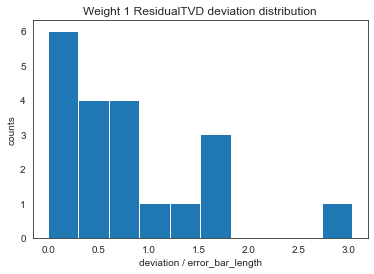

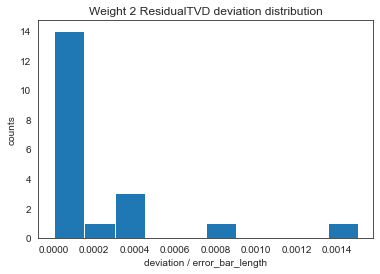

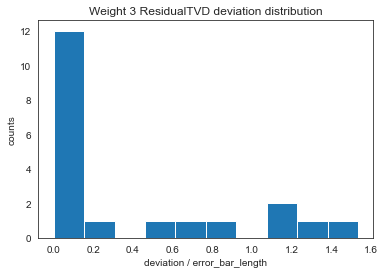

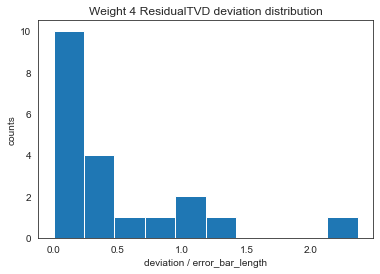

In [20]:
test_errorbars({'0000': 0.45, '0001': 0.05, '1111': 0.5}) # weight 1 movement 

Base weight-1 disturbance = 0
Base weight-2 disturbance = 0.05
Base weight-3 disturbance = 3.37029e-09
Base weight-4 disturbance = 0
Check 1 of 20
Weight-1 disturbance = 2.08167e-17 +/- 0.000320226  (deviation=6.48037959331721e-14)
Weight-2 disturbance = 0.0501997 +/- 0.00186102  (deviation=0.10723393001260678)
Weight-3 disturbance = 3.31702e-07 +/- 9.26582e-05  (deviation=0.0035056417084368204)
Weight-4 disturbance = 0 +/- 0.00130098  (deviation=0.0)
Check 2 of 20
Weight-1 disturbance = 0 +/- 0.00032646  (deviation=0.0)
Weight-2 disturbance = 0.0518 +/- 0.0021478  (deviation=0.8376683990201109)
Weight-3 disturbance = 2.12999e-08 +/- 0.000127726  (deviation=0.00013928557711311918)
Weight-4 disturbance = 0 +/- 0.0035868  (deviation=0.0)
Check 3 of 20
Weight-1 disturbance = 0 +/- 0.000292508  (deviation=0.0)
Weight-2 disturbance = 0.0490996 +/- 0.00207274  (deviation=0.43418023406088485)
Weight-3 disturbance = 3.81996e-07 +/- 0.000128251  (deviation=0.002929390154444396)
Weight-4 disturb

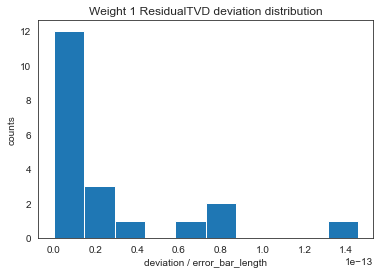

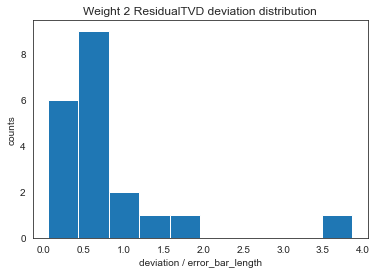

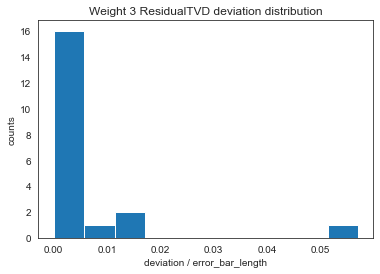

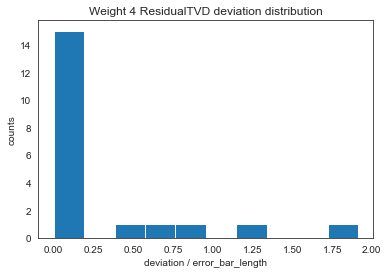

In [21]:
test_errorbars({'0000': 0.45, '0011': 0.05, '1111': 0.5}) # weight 2 movement 

Base weight-1 disturbance = 6.93889e-18
Base weight-2 disturbance = -6.93889e-18
Base weight-3 disturbance = 0.0499999
Base weight-4 disturbance = 6.40582e-08
Check 1 of 20
Weight-1 disturbance = 0.0107 +/- 0.00735355  (deviation=1.454881238330978)
Weight-2 disturbance = -2.63725e-09 +/- 0.000296416  (deviation=8.867232567089432e-06)
Weight-3 disturbance = 0.0395 +/- 0.00666818  (deviation=1.5744026062431984)
Weight-4 disturbance = 4.75707e-08 +/- 0.000755664  (deviation=2.178970913195027e-05)
Check 2 of 20
Weight-1 disturbance = 0.0037 +/- 0.00562772  (deviation=0.6573434556666093)
Weight-2 disturbance = -4.42276e-07 +/- 0.000307611  (deviation=0.001433119022133044)
Weight-3 disturbance = 0.0481001 +/- 0.00512665  (deviation=0.3705071575464912)
Weight-4 disturbance = 3.37135e-07 +/- 0.0035827  (deviation=7.619955664119643e-05)
Check 3 of 20
Weight-1 disturbance = 0.004 +/- 0.00563871  (deviation=0.7092557790160376)
Weight-2 disturbance = -3.25228e-08 +/- 0.000276748  (deviation=0.0001

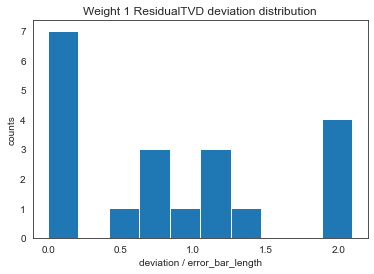

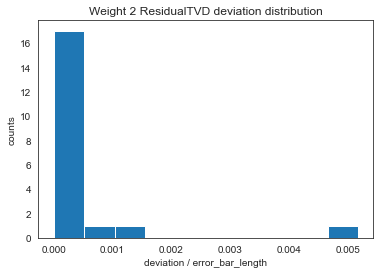

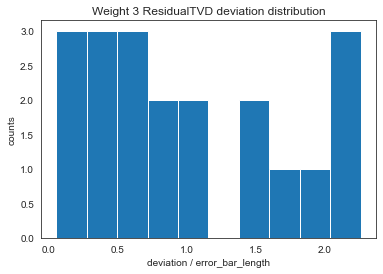

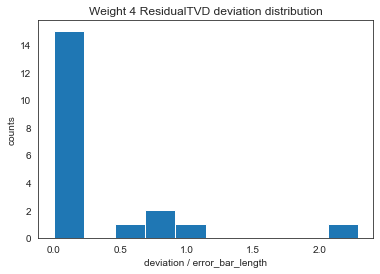

In [22]:
test_errorbars({'0000': 0.45, '0111': 0.05, '1111': 0.5}) # weight 3 movement 

Base weight-1 disturbance = 0
Base weight-2 disturbance = 0
Base weight-3 disturbance = 0
Base weight-4 disturbance = 0.05
Check 1 of 20
Weight-1 disturbance = 0 +/- 0.000223133  (deviation=0.0)
Weight-2 disturbance = 0 +/- 0.00027576  (deviation=0.0)
Weight-3 disturbance = 0 +/- 0.000312568  (deviation=0.0)
Weight-4 disturbance = 0.0395 +/- 0.00661217  (deviation=1.5877420124959105)
Check 2 of 20
Weight-1 disturbance = 0 +/- 0.000223139  (deviation=0.0)
Weight-2 disturbance = 0 +/- 0.000275264  (deviation=0.0)
Weight-3 disturbance = 0 +/- 0.000315445  (deviation=0.0)
Weight-4 disturbance = 0.0481 +/- 0.00661172  (deviation=0.28732501691130974)
Check 3 of 20
Weight-1 disturbance = 0 +/- 0.000222312  (deviation=0.0)
Weight-2 disturbance = 0 +/- 0.000275191  (deviation=0.0)
Weight-3 disturbance = 0 +/- 0.000315324  (deviation=0.0)
Weight-4 disturbance = 0.0451 +/- 0.00661149  (deviation=0.7410214778902107)
Check 4 of 20
Weight-1 disturbance = 0 +/- 0.000223168  (deviation=0.0)
Weight-2 d

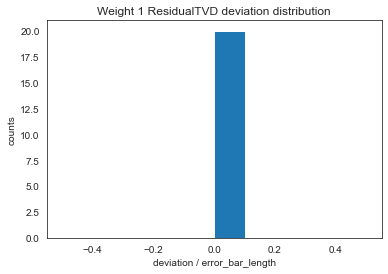

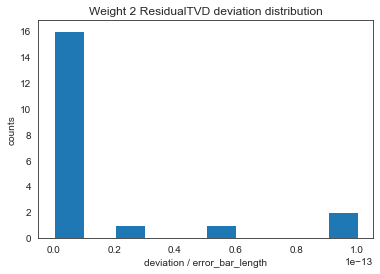

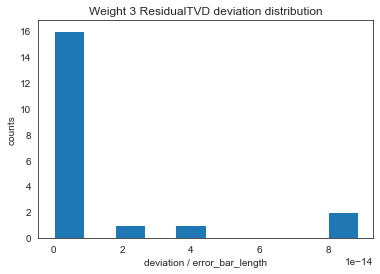

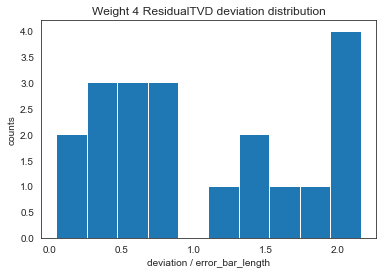

In [23]:
test_errorbars({'0000': 0.45, '1111': 0.55}) # weight 4 movement 